In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
!pip install fastapi
!pip install uvicorn
!pip install nest_asyncio
!pip install python-multipart
import nest_asyncio
nest_asyncio.apply()

In [ ]:
!pip install flask-ngrok

In [ ]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 54.5 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [ ]:
%load_ext tensorboard

In [ ]:
import os
import torch
import shutil
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from sklearn.preprocessing import MinMaxScaler
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from torchmetrics import MeanAbsoluteError

In [ ]:
# 데이터 경로 설정
data_path = "/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/final_preprocessed_format.csv"

# 데이터 로드
df_total = pd.read_csv(data_path)

# 스케일링
scaler = MinMaxScaler()
df_total['feed_pressure'] = scaler.fit_transform(df_total[['feed_pressure']])

# 시간 인덱스 추가 (필요하다면 데이터셋에 이미 포함되어 있는 time_idx 확인)
if 'time_idx' not in df_total.columns:
    df_total['time_idx'] = range(len(df_total))

# 그룹 ID 설정 (단일 시계열일 경우 고정값 사용)
if 'group' not in df_total.columns:
    df_total["group"] = "series"

# max_encoder_length와 max_prediction_length 설정
total_data_length = len(df_total)
max_encoder_length = max(10, total_data_length // 10)
max_prediction_length = 1

print(f"Max encoder length: {max_encoder_length} entries")
print(f"Max prediction length: {max_prediction_length} entries")

Max encoder length: 5594 entries
Max prediction length: 1 entries


### TimeSeriesDataSet 생성
TimeSeriesDataSet을 사용해 데이터를 생성합니다. 여기에는 타겟, 그룹화 방식, 그리고 변동하는 시계열 컬럼을 정의합니다.


In [ ]:
# 학습 및 검증 데이터 분할 (80% 학습, 20% 검증)
train_size = int(total_data_length * 0.8)
df_train = df_total.iloc[:train_size]
df_val = df_total.iloc[train_size:]

# TimeSeriesDataSet 설정
training = TimeSeriesDataSet(
    df_train,  # 학습 데이터만 사용
    time_idx="time_idx",
    target="feed_pressure",  # 타겟 변수
    group_ids=["group"],  # 그룹화
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_reals=["time_idx"],  # 시간 관련 변수
    time_varying_unknown_reals=["feed_pressure"],  # 예측 대상 변수
    target_normalizer=GroupNormalizer(transformation="relu")  # 정규화
)

# 검증 데이터셋 생성
validation = TimeSeriesDataSet.from_dataset(training, df_val)

### DataLoader 생성
DataLoader를 생성하여 모델이 데이터를 학습할 수 있도록 준비합니다.

### Temporal Fusion Transformer 모델 생성
Temporal Fusion Transformer 모델을 생성하여 데이터셋을 학습할 준비를 합니다.

### LightningModule 정의 및 Trainer 설정
PyTorch Lightning을 이용하여 모델 학습을 보다 쉽게 관리할 수 있도록 합니다.


In [ ]:
# 데이터 로더 생성
train_dataloader = training.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=32, num_workers=0)

from torchmetrics import MeanAbsoluteError

# Define the loss function
loss = MeanAbsoluteError()

# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,  # 학습률
    hidden_size=16,  # 모델의 잠재 표현 크기
    attention_head_size=1,  # 어텐션 헤드 개수 (패턴 포착)
    dropout=0.1,  # 과적합 방지
    hidden_continuous_size=16,  # 연속형 변수의 임베딩 크기
    loss=loss,  # 손실 함수 (loss 변수 사용)
    log_interval=10,  # 학습 로그 출력 빈도
    reduce_on_plateau_patience=3,  # 손실이 개선되지 않을 시 학습률 줄이는 시점
    optimizer="adam"
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
# TFTWrapper 클래스 수정
class TFTWrapper(pl.LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model
        self.train()  # 학습 모드로 설정

    def forward(self, x):
        # 모든 입력 데이터를 모델의 디바이스로 이동
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}

        # 모델의 모든 파라미터를 디바이스로 이동
        self.tft_model.to(device)

        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        # 학습 모드로 전환
        self.train()
        x, y = batch

        # 입력 데이터와 타겟을 모델의 디바이스로 이동
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        y = y[0] if isinstance(y, tuple) else y
        y = y.to(device)

        # 예측 및 손실 계산
        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        # 입력 데이터와 타겟을 모델의 디바이스로 이동
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in x.items()}
        y = y[0] if isinstance(y, tuple) else y
        y = y.to(device)

        # 예측 및 손실 계산
        y_hat = self(x)["prediction"]
        loss = self.tft_model.loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.03)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]

In [ ]:
# Google Drive에 저장된 체크포인트 경로
checkpoint_path = "/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt"

# 모델 학습 및 체크포인트 설정
local_checkpoint_dir = "/content/checkpoints/"
drive_checkpoint_dir = "/content/drive/MyDrive/종설프1_5팀/checkpoints/"
os.makedirs(local_checkpoint_dir, exist_ok=True)
os.makedirs(drive_checkpoint_dir, exist_ok=True)

# 기존 체크폰트 파일 삭제 함수
def delete_existing_checkpoints(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        for filename in os.listdir(checkpoint_dir):
            file_path = os.path.join(checkpoint_dir, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    print(f"Deleted checkpoint file: {file_path}")
            except Exception as e:
                print(f"Failed to delete {file_path}: {e}")


# 가장 최근 체크포인트 찾기
def get_latest_checkpoint(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        checkpoints = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt")]
        if checkpoints:
            return max(checkpoints, key=os.path.getctime)  # 가장 최근 파일 반환
    return None

### Optuna 활용

In [ ]:
# Objective 함수 정의
def objective(trial):
    # 하이퍼파라미터 정의
    hidden_size = trial.suggest_int("hidden_size", 8, 64)
    attention_head_size = trial.suggest_int("attention_head_size", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # Temporal Fusion Transformer 모델 생성
    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=learning_rate,
        hidden_size=hidden_size,
        attention_head_size=attention_head_size,
        dropout=dropout,
        hidden_continuous_size=16,
        loss=loss,
        log_interval=10,
        reduce_on_plateau_patience=3
    )

    # 모델을 명시적으로 GPU로 이동
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tft.to(device)
    wrapped_tft = TFTWrapper(tft).to(device)

    # 고유한 체크포인트 경로 생성
    checkpoint_callback = ModelCheckpoint(
        dirpath=f"{local_checkpoint_dir}/trial_{trial.number}",
        filename="tft-{epoch:02d}-{val_loss:.2f}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=True
    )

    # EarlyStopping 설정
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=3,  # patience를 줄여 빠르게 중단
        verbose=True,
        mode="min"
    )

    logger = TensorBoardLogger("lightning_logs", name=f"tft_trial_{trial.number}")

    trainer = Trainer(
        max_epochs=10,  # 실행 시간을 고려한 적절한 에포크
        accelerator="gpu",
        devices=1,
        gradient_clip_val=0.3,
        precision=32,
        callbacks=[checkpoint_callback, early_stop_callback],
        logger=logger
    )

    # 모델 학습
    trainer.fit(
        model=wrapped_tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

    # 최종 검증 손실 반환
    val_loss = trainer.callback_metrics.get("val_loss", None)
    if val_loss is None:
        raise ValueError("Validation loss is not available.")
    return val_loss.item()

# Optuna 스터디 생성 및 최적화 수행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)  # 10번의 시도

# 최적의 하이퍼파라미터 출력
print("Best parameters:", study.best_params)
print("Best validation loss:", study.best_value)

In [ ]:
best_params = {
    "hidden_size": 29,
    "attention_head_size": 3,
    "dropout": 0.34884270911702864,
    "learning_rate": 0.0013095831847880091
}

## 모델 학습

<span style="color:red;">주의: 체크포인트 삭제!</span>

In [ ]:
# TFT 모델 생성 및 최적 하이퍼파라미터 반영
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=best_params["learning_rate"],  # Optuna 최적화된 학습률
    hidden_size=best_params["hidden_size"],  # Optuna 최적화된 hidden_size
    attention_head_size=best_params["attention_head_size"],  # Optuna 최적화된 attention_head_size
    dropout=best_params["dropout"],  # Optuna 최적화된 dropout
    hidden_continuous_size=16,  # 기본값 유지
    loss=loss,
    log_interval=10,
    reduce_on_plateau_patience=3
)

# TFTWrapper로 감싸기 및 GPU로 이동
tft.to('cuda')
wrapped_tft = TFTWrapper(tft).to('cuda')

# Checkpoint 콜백 설정
checkpoint_callback = ModelCheckpoint(
    dirpath=local_checkpoint_dir,
    filename="tft-best",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True
)

# EarlyStopping 콜백
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=True,
    mode="min"
)

# Logger 설정
logger = TensorBoardLogger("lightning_logs", name="tft_final")

# Trainer 설정
trainer = Trainer(
    max_epochs=50,  # 최종 학습
    accelerator="gpu",
    devices=1,
    gradient_clip_val=0.3,
    precision=32,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# 기존 체크포인트에서 로드 여부 확인 및 학습 실행
delete_checkpoints = input("기존 체크포인트 파일을 삭제하시겠습니까? (y/n): ").lower()

if delete_checkpoints == 'y':
    print("기존 체크포인트 파일을 삭제합니다.")
    delete_existing_checkpoints(local_checkpoint_dir)
    delete_existing_checkpoints(drive_checkpoint_dir)

    # 새 학습 시작
    trainer.fit(
        model=wrapped_tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )

else:
    print("기존 체크포인트를 유지합니다.")
    latest_checkpoint = get_latest_checkpoint(local_checkpoint_dir)

    if latest_checkpoint:
        print(f"기존 체크포인트에서 로드합니다: {latest_checkpoint}")

        # 체크포인트에서 모델 로드
        loaded_tft = TemporalFusionTransformer.load_from_checkpoint(
            latest_checkpoint,
            map_location=torch.device('cuda')
        )

        # TFTWrapper로 래핑 및 GPU로 이동
        wrapped_tft = TFTWrapper(tft_model=loaded_tft).to('cuda')

        # 기존 체크포인트에서 로드한 모델로 학습 재개
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )

    else:
        print("체크포인트가 없습니다. 새로 학습을 시작합니다.")

        # 새 학습 시작
        trainer.fit(
            model=wrapped_tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )

기존 체크포인트 파일을 삭제하시겠습니까? (y/n): y


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode
---------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 48.8 K | eval
---------------------------------------------------------------
48.8 K    Trainable params
0         Non-trainable params
48.8 K    Total params
0.195     Total estimated model params size (MB)
0         Modules in train mode
176       Modules in eval mode


기존 체크포인트 파일을 삭제합니다.
Deleted checkpoint file: /content/checkpoints/tft-best.ckpt
Deleted checkpoint file: /content/checkpoints/last.ckpt
Deleted checkpoint file: /content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [20]:
# 학습 종료 후 가장 좋은 체크포인트 경로 출력
print(f"Best checkpoint saved at: {checkpoint_callback.best_model_path}")

Best checkpoint saved at: /content/checkpoints/tft-best.ckpt


In [21]:
# 학습이 끝난 후 로컬 체크포인트를 Google Drive로 복사
shutil.copyfile(
    os.path.join(local_checkpoint_dir, "tft-best.ckpt"),
    os.path.join(drive_checkpoint_dir, "tft-best.ckpt")
)

'/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt'

## 서버구축

In [29]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


--2024-12-08 22:26:27--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 75.2.60.68, 35.71.179.82, 13.248.244.96, ...
Connecting to bin.equinox.io (bin.equinox.io)|75.2.60.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  8.93MB/s    in 1.5s    

2024-12-08 22:26:29 (8.93 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [30]:
!./ngrok authtoken cr_2pQNo2X1zqJCJbgu2vzvGoq8ubY

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## 모델 다시 로드

In [22]:
# Google Drive에 저장된 체크포인트 경로
checkpoint_path = "/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best.ckpt"

# TemporalFusionTransformer 모델 생성
loaded_tft = TemporalFusionTransformer.from_dataset(
    training,  # 동일한 데이터셋 필요
    learning_rate=best_params["learning_rate"],
    hidden_size=best_params["hidden_size"],
    attention_head_size=best_params["attention_head_size"],
    dropout=best_params["dropout"],
    hidden_continuous_size=16,
    loss=MeanAbsoluteError(),
    log_interval=10,
    reduce_on_plateau_patience=3
)

# 체크포인트 로드
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))  # GPU로 로드

# state_dict 키 이름 수정
state_dict = checkpoint["state_dict"]
new_state_dict = {k.replace("tft_model.", ""): v for k, v in state_dict.items()}  # 접두사 제거

# 수정된 state_dict를 모델에 로드
loaded_tft.load_state_dict(new_state_dict)
loaded_tft.to('cuda')  # GPU로 이동
loaded_tft.eval()

<ipython-input-22-8e065c542b83>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))  # GPU로 로드


TemporalFusionTransformer(
  	"attention_head_size":               3
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'feed_pressure', 'group_ids': ['group'], 'weight': None, 'max_encoder_length': 5594, 'min_encoder_length': 5594, 'min_prediction_idx': 0, 'min_prediction_length': 1, 'max_prediction_length': 1, 'static_categoricals': [], 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['time_idx'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['feed_pressure'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': False, 'lags': None, 'add_relative_time_idx': False, 'add_target_scales': False, 'add_encoder_length': False, 'target_normalizer': GroupNormalizer(
  		method='standard',
  		groups=None,
  		center=True,
  		scale_by_group=False,
  		transformation='relu',
  		meth

## ROLLING 방식

In [23]:
# 'group' 컬럼 확인 및 추가
if "group" not in df_total.columns or df_total["group"].isnull().any():
    print("'group' 컬럼이 누락되었거나 비어 있습니다. 기본 그룹 값을 설정합니다.")
    df_total["group"] = "series"  # 기본 그룹 값 설정

In [24]:
# 'group' 컬럼 고유성 확인
if df_total["group"].nunique() > 1:
    print(f"'group' 컬럼에 {df_total['group'].nunique()}개의 고유 값이 있습니다. 모델이 단일 그룹을 예상할 수 있으니 확인하세요.")

# Rolling Prediction 실행 전에 데이터 유효성 확인
if len(df_total) < max_encoder_length:
    print(
        f"데이터셋 길이 ({len(df_total)})가 max_encoder_length ({max_encoder_length})보다 짧습니다. "
        "데이터를 패딩하여 문제를 해결합니다."
    )
    # 필요한 패딩 길이 계산
    padding_length = max_encoder_length - len(df_total)
    last_row = df_total.iloc[-1]
    padding = pd.DataFrame([last_row] * padding_length)

    # time_idx를 늘리기
    padding["time_idx"] = range(df_total["time_idx"].max() + 1, df_total["time_idx"].max() + 1 + padding_length)

    # 패딩 추가
    df_total = pd.concat([df_total, padding], ignore_index=True)
    print(f"데이터셋이 {len(df_total)}로 패딩되었습니다.")


In [25]:
# rolling_predict_batch 수정
def rolling_predict_batch(
    model, train_dataset, max_encoder_length, scaler, condition_value=17, tolerance=0.1, batch_size=1, device="cuda"
):
    """
    Rolling 방식으로 한 번에 batch_size만큼 예측을 수행하며 조건 만족 시까지 반복합니다.

    Args:
        model: PyTorch 모델.
        train_dataset: 학습에 사용된 데이터셋 (DataFrame 형태).
        max_encoder_length: 롤링 윈도우의 길이.
        scaler: MinMaxScaler (스케일링 복원을 위해 필요).
        condition_value: 예측이 중단되는 조건 값 (예: 17).
        tolerance: 조건 값에 대한 허용 오차.
        batch_size: 한 번에 예측할 예측 길이 (기본: 1).
        device: 사용할 디바이스 (default: "cuda").

    Returns:
        predictions (list): 예측된 값의 리스트.
    """
    model = model.to(device)
    model.eval()

    # Initialize with the first encoder window from the training data
    input_data = train_dataset.iloc[:max_encoder_length].copy()
    predictions = []

    # Add group column if missing
    if "group" not in input_data.columns:
        input_data["group"] = "series"

    step = 0
    while True:
        try:
            # Create TimeSeriesDataSet for rolling prediction
            rolling_dataset = TimeSeriesDataSet(
                data=input_data,
                time_idx="time_idx",
                target="feed_pressure",
                group_ids=["group"],
                max_encoder_length=max_encoder_length,
                max_prediction_length=batch_size,
                static_categoricals=[],
                time_varying_known_reals=["time_idx"],
                time_varying_unknown_reals=["feed_pressure"],
                target_normalizer=GroupNormalizer(transformation="relu"),
                min_encoder_length=1,
                allow_missing_timesteps=True,
            )

            rolling_dataloader = rolling_dataset.to_dataloader(train=False, batch_size=1)

            # Predict the next value
            with torch.no_grad():
                input_batch = next(iter(rolling_dataloader))
                input_batch = {key: value.to(device) for key, value in input_batch[0].items()}
                batch_predictions = model(input_batch)["prediction"].cpu().numpy().squeeze()

            # Restore the scaled prediction to original scale
            batch_predictions_actual = scaler.inverse_transform(batch_predictions.reshape(-1, 1)).flatten()
            predictions.extend(batch_predictions_actual)

            print(f"Step {step}: Predicted Value = {batch_predictions_actual[0]}")

            # Check if the prediction meets the condition
            if abs(batch_predictions_actual[0] - condition_value) <= tolerance:
                print(f"Condition met: Predicted value is within tolerance of {condition_value}. Stopping prediction.")
                break

            # Update rolling input data with the new predicted value
            new_time_idx = input_data["time_idx"].iloc[-1] + 1
            new_row = {
                "time_idx": new_time_idx,
                "feed_pressure": batch_predictions_actual[0],
                "group": "series",
            }
            input_data = pd.concat([input_data.iloc[1:], pd.DataFrame([new_row])], ignore_index=True)

            step += 1

        except Exception as e:
            print(f"Error at step {step}: {e}")
            break

    return predictions

In [26]:
def rolling_predict_batch(
    model, train_dataset, max_encoder_length, scaler, condition_value=17, tolerance=0.1, batch_size=1, device="cuda"
):
    model = model.to(device)
    model.eval()

    # Initialize with the first encoder window from the training data
    input_data = train_dataset.iloc[:max_encoder_length].copy()
    predictions = []

    # Add group column if missing
    if "group" not in input_data.columns:
        input_data["group"] = "series"

    step = 0
    while True:
        try:
            # Create rolling dataset
            rolling_dataset = TimeSeriesDataSet(
                data=input_data,
                time_idx="time_idx",
                target="feed_pressure",
                group_ids=["group"],
                max_encoder_length=max_encoder_length,
                max_prediction_length=batch_size,
                static_categoricals=[],
                time_varying_known_reals=["time_idx"],
                time_varying_unknown_reals=["feed_pressure"],
                target_normalizer=GroupNormalizer(transformation="relu"),
                min_encoder_length=1,
                allow_missing_timesteps=True,
            )

            # Create rolling dataloader
            rolling_dataloader = rolling_dataset.to_dataloader(train=False, batch_size=1)

            # Perform prediction
            with torch.no_grad():
                input_batch = next(iter(rolling_dataloader))
                input_batch = {key: value.to(device) for key, value in input_batch[0].items()}
                batch_predictions = model(input_batch)["prediction"].cpu().numpy().squeeze()

            # Scale back to original
            batch_predictions_actual = scaler.inverse_transform(batch_predictions.reshape(-1, 1)).flatten()
            predictions.extend(batch_predictions_actual)

            # Check stopping condition
            diff = abs(batch_predictions_actual[0] - condition_value)
            print(f"Step {step}: Predicted Value = {batch_predictions_actual[0]}, Difference = {diff}")

            if batch_predictions_actual[0] >= condition_value:
                print(f"Condition met: Predicted value = {batch_predictions_actual[0]} >= {condition_value}. Stopping.")
                break

            # Update input data for rolling prediction
            new_time_idx = input_data["time_idx"].iloc[-1] + 1
            new_row = {
                "time_idx": new_time_idx,
                "feed_pressure": batch_predictions_actual[0],
                "group": "series",
            }
            input_data = pd.concat([input_data.iloc[1:], pd.DataFrame([new_row])], ignore_index=True)

            step += 1

        except Exception as e:
            print(f"Error at step {step}: {e}")
            break

    return predictions

In [27]:
rolling_predictions = rolling_predict_batch(
    model=wrapped_tft,
    train_dataset=df_total,
    max_encoder_length=max_encoder_length,
    scaler=scaler,
    condition_value=17,
    tolerance=0.1,
    batch_size=1,
    device="cuda",
)

print("Final Predictions:", rolling_predictions)

Step 0: Predicted Value = 10.413405418395996, Difference = 6.586594581604004
Step 1: Predicted Value = 11.058327674865723, Difference = 5.941672325134277
Step 2: Predicted Value = 11.513411521911621, Difference = 5.486588478088379
Step 3: Predicted Value = 11.89936351776123, Difference = 5.1006364822387695
Step 4: Predicted Value = 12.246939659118652, Difference = 4.753060340881348
Step 5: Predicted Value = 12.569581985473633, Difference = 4.430418014526367
Step 6: Predicted Value = 12.874577522277832, Difference = 4.125422477722168
Step 7: Predicted Value = 13.166400909423828, Difference = 3.833599090576172
Step 8: Predicted Value = 13.448031425476074, Difference = 3.551968574523926
Step 9: Predicted Value = 13.721567153930664, Difference = 3.278432846069336
Step 10: Predicted Value = 13.988557815551758, Difference = 3.011442184448242
Step 11: Predicted Value = 14.250222206115723, Difference = 2.7497777938842773
Step 12: Predicted Value = 14.507474899291992, Difference = 2.49252510070

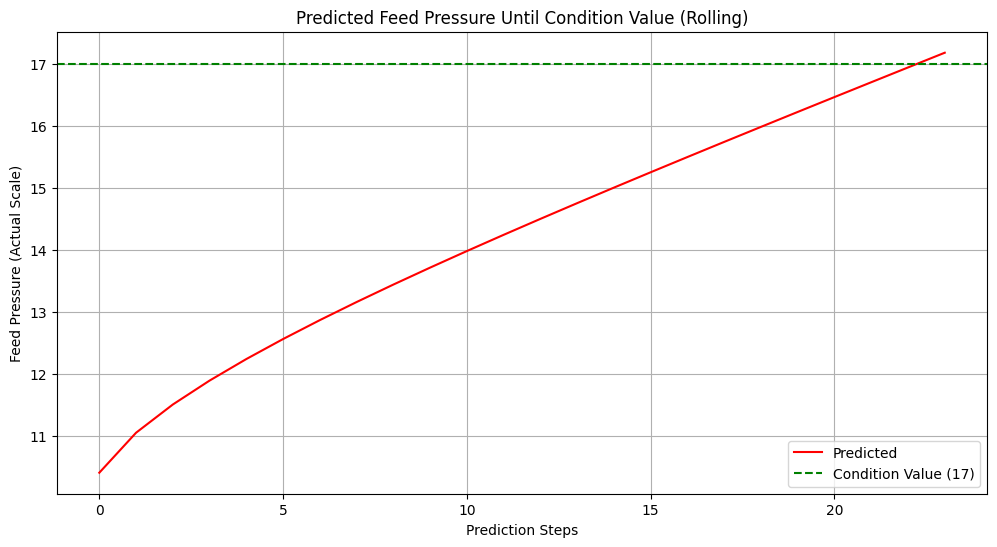

In [28]:
# 결과 시각화 함수
def plot_rolling_predictions(predicted_values, condition_value=17):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(predicted_values)), predicted_values, label="Predicted", linestyle="-", color="red")
    plt.axhline(y=condition_value, color="green", linestyle="--", label=f"Condition Value ({condition_value})")
    plt.xlabel("Prediction Steps")
    plt.ylabel("Feed Pressure (Actual Scale)")
    plt.title("Predicted Feed Pressure Until Condition Value (Rolling)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Rolling Predictions 그래프 호출
plot_rolling_predictions(rolling_predictions, condition_value=17)


###  Api System

In [40]:
from fastapi import FastAPI, UploadFile, File
from pydantic import BaseModel
import pandas as pd
import torch
from pytorch_lightning import Trainer
from sklearn.preprocessing import MinMaxScaler
import os
from matplotlib import pyplot as plt

# Import necessary modules and classes from your existing code
# from your_code import TemporalFusionTransformer, rolling_predict_batch, plot_rolling_predictions

# Initialize FastAPI app
app = FastAPI()

# Global variables
tft_model = None  # Placeholder for the trained model
scaler = MinMaxScaler()
max_encoder_length = 10
condition_value = 17

# Define request model for predict endpoint
class PredictRequest(BaseModel):
    condition_value: float = 17.0
    tolerance: float = 0.1
    batch_size: int = 1

# Define the model loading function
def load_model(model_path, training_dataset, best_params):
    global tft_model

    # TemporalFusionTransformer model creation
    tft_model = TemporalFusionTransformer.from_dataset(
        training_dataset,
        learning_rate=best_params["learning_rate"],
        hidden_size=best_params["hidden_size"],
        attention_head_size=best_params["attention_head_size"],
        dropout=best_params["dropout"],
        hidden_continuous_size=16,
        loss=torch.nn.MSELoss(),
        log_interval=10,
        reduce_on_plateau_patience=3
    )

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=torch.device('cuda'))
    state_dict = checkpoint["state_dict"]
    new_state_dict = {k.replace("tft_model.", ""): v for k, v in state_dict.items()}

    # Load state dict
    tft_model.load_state_dict(new_state_dict)
    tft_model.to('cuda')
    tft_model.eval()
    print("Model loaded successfully.")

# Define the predict endpoint
@app.post("/predict")
async def predict(request: PredictRequest, file: UploadFile = File(...)):
    global tft_model, scaler

    # Ensure the model is loaded
    if tft_model is None:
        return {"error": "Model not loaded. Please load the model first."}

    # Read the uploaded CSV file into a DataFrame
    try:
        df = pd.read_csv(file.file)
    except Exception as e:
        return {"error": f"Failed to load CSV file: {str(e)}"}

    # Data preprocessing
    if "feed_pressure" not in df.columns:
        return {"error": "CSV file must contain a 'feed_pressure' column."}

    df["feed_pressure"] = scaler.transform(df[["feed_pressure"]])  # Apply existing scaler
    df["time_idx"] = range(len(df))
    if "group" not in df.columns:
        df["group"] = "series"

    # Validate dataset length for rolling prediction
    if len(df) < max_encoder_length:
        padding_length = max_encoder_length - len(df)
        last_row = df.iloc[-1]
        padding = pd.DataFrame([last_row] * padding_length)
        padding["time_idx"] = range(df["time_idx"].max() + 1, df["time_idx"].max() + 1 + padding_length)
        df = pd.concat([df, padding], ignore_index=True)
        print(f"Dataset padded to {len(df)} rows.")

    # Perform rolling predictions
    predictions = rolling_predict_batch(
        model=tft_model,
        train_dataset=df,
        max_encoder_length=max_encoder_length,
        scaler=scaler,
        condition_value=request.condition_value,
        tolerance=request.tolerance,
        batch_size=request.batch_size,
        device="cuda"
    )

    return {"predictions": predictions}

# Define the root endpoint
@app.get("/")
def read_root():
    return {"message": "TFT API is running. Use /predict endpoint to make predictions."}

# Define a model loading endpoint
@app.post("/load_model")
def load_model_endpoint(model_path: str, training_dataset_path: str, best_params: dict):
    try:
        # Load training dataset
        training_df = pd.read_csv(training_dataset_path)

        # Preprocess the training dataset
        training_df["feed_pressure"] = scaler.fit_transform(training_df[["feed_pressure"]])
        training_df["time_idx"] = range(len(training_df))
        if "group" not in training_df.columns:
            training_df["group"] = "series"

        # Create training TimeSeriesDataSet
        training_dataset = TimeSeriesDataSet(
            training_df,
            time_idx="time_idx",
            target="feed_pressure",
            group_ids=["group"],
            max_encoder_length=max_encoder_length,
            max_prediction_length=1,
            static_categoricals=[],
            time_varying_known_reals=["time_idx"],
            time_varying_unknown_reals=["feed_pressure"],
            target_normalizer=GroupNormalizer(transformation="relu")
        )

        # Load the model
        load_model(model_path, training_dataset, best_params)

        return {"message": "Model loaded successfully."}
    except Exception as e:
        return {"error": f"Failed to load model: {str(e)}"}

In [41]:
# 앱 실행 코드
import uvicorn
uvicorn.run(app, host="0.0.0.0", port=8000)

INFO:     Started server process [3501]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [3501]
